# Local Feature Matching

By the end of this exercise, you will be able to transform images of a flat (planar) object, or images taken from the same point into a common reference frame. This is at the core of applications such as panorama stitching.

A quick overview:

1. We will start with histogram representations for images (or image regions).
2. Then we will detect robust keypoints in images and use simple histogram descriptors to describe the neighborhood of each keypoint.
3. After this we will compare descriptors from different images using a distance function and establish matching points.
4. Using these matching points we will estimate the homography transformation between two images of a planar object (wall with graffiti) and use this to warp one image to look like the other.

**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. Submit in **teams of 3 or 4 students**, add their names and matriculation numbers below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

Team members (names and matriculation numbers):
* 
* 
* 
* 

In [154]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import math
from scipy import ndimage
from attrdict import AttrDict
from mpl_toolkits.mplot3d import Axes3D

# Many useful functions
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=6, imheight=6, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
        
def load_image(f_name):
    return imageio.imread(f_name, as_gray=True).astype(np.float32)/255

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def gauss(x, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- x**2 / 2 / sigma**2)

def gaussdx(x, sigma):
    return (-1 / np.sqrt(2 * np.pi) / sigma**3 * x *
            np.exp(- x**2 / 2 / sigma**2))

def gauss_derivs(image, sigma):
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    image_dx = convolve_with_two(image, D, G.T)
    image_dy = convolve_with_two(image, G, D.T)
    return image_dx, image_dy

def gauss_filter(image, sigma):
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    return convolve_with_two(image, G, G.T)

def gauss_second_derivs(image, sigma):
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    
    image_dx, image_dy = gauss_derivs(image, sigma) 
    image_dxx = convolve_with_two(image_dx, D, G.T)
    image_dyy = convolve_with_two(image_dy, G, D.T)
    image_dxy = convolve_with_two(image_dx, G, D.T)
    return image_dxx, image_dxy, image_dyy

def map_range(x, start, end):
    """Maps values `x` that are within the range [start, end) to the range [0, 1)
    Values smaller than `start` become 0, values larger than `end` become
    slightly smaller than 1."""
    return np.clip((x-start)/(end-start), 0, 1-1e-10)

def draw_keypoints(image, points):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    radius = image.shape[1]//100+1
    for x, y in points:
        cv2.circle(image, (int(x), int(y)), radius, (1, 0, 0), thickness=2)        
    return image

def draw_point_matches(im1, im2, point_matches):
    result = np.concatenate([im1, im2], axis=1)
    result = (result.astype(float)*0.6).astype(np.uint8)
    im1_width = im1.shape[1]
    for x1, y1, x2, y2 in point_matches:
        cv2.line(result, (x1, y1), (im1_width+x2, y2), 
                 color=(0,255,255), thickness=2, lineType=cv2.LINE_AA)
    return result

In [155]:
%%html
<!-- This adds heading numbers to each section header -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

## Histograms in 1D

If we have a grayscale image, creating a histogram of the gray values tells us how frequently each gray value appears in the image, at a certain discretization level, which is controlled by the number of bins.

Implement `compute_1d_histogram(im, n_bins)`. Given an grayscale image `im` with shape `[height, width]` and the number of bins `n_bins`, return a `histogram` array that contains the number of values falling into each bin. Assume that the values (of the image) are in the range \[0,1), so the specified number of bins should cover the range from 0 to 1. Normalize the resulting histogram to sum to 1. What is the effect of the different bin counts?

In [156]:
# POINTS: 3

def compute_1d_histogram(im, n_bins):
    
    def normalize(matrix): #https://www.geeksforgeeks.org/how-to-normalize-an-array-in-numpy-in-python/
        norm = np.linalg.norm(matrix)
        matrix = matrix/norm  # normalized matrix
        return matrix

    histogram = np.zeros(n_bins)
    distance = 1/n_bins #range of each bin
    
    bins = np.arange(0.0, 1.0, distance) #creates bins
    bin_assignment = np.digitize(im, bins) - 1 #assigns bin value to every pixel
    size = (im.shape[0] * im.shape[1], 1) #shape for 2D - 1D

    histogram = np.bincount(bin_assignment.reshape(size)[:, 0], minlength=n_bins) #bincount - frequency of each bin
    histogram = normalize(histogram)
    
    return histogram

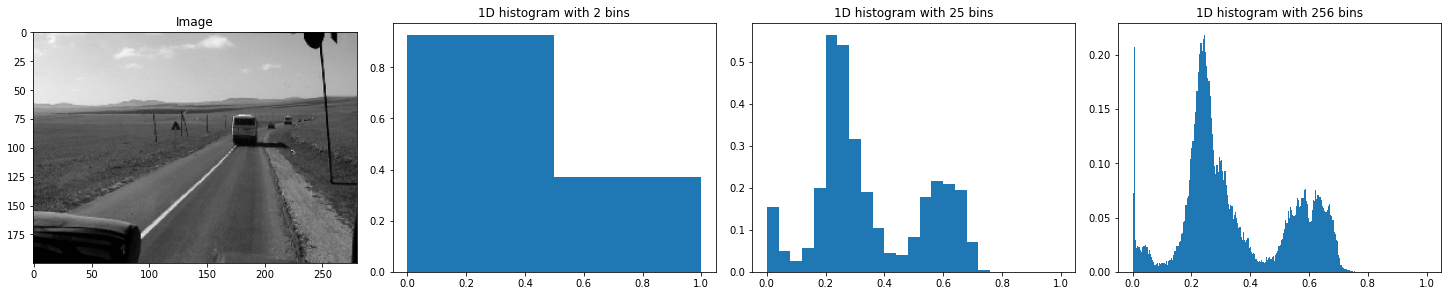

In [157]:
fig, axes = plt.subplots(1,4, figsize=(20,4), constrained_layout=True)
bin_counts = [2, 25, 256]
gray_img = imageio.imread('terrain.png', as_gray=True
                         ).astype(np.float32)/256

axes[0].set_title('Image')
axes[0].imshow(gray_img, cmap='gray')
for ax, n_bins in zip(axes[1:], bin_counts):
    ax.set_title(f'1D histogram with {n_bins} bins')
    bin_size = 1/n_bins
    x_axis = np.linspace(0, 1, n_bins, endpoint=False)+bin_size/2
    hist = compute_1d_histogram(gray_img, n_bins)
    ax.bar(x_axis, hist, bin_size)

## Histograms in 3D

If the pixel values are more than one-dimensional (e.g. three-dimensional RGB, for red, green and blue color channels), we can build a multi-dimensional histogram. In the R, G, B example this will tell us how frequently each *combination* of R, G, B values occurs. (Note that this contains more information than simply building 3 one-dimensional histograms, each for R, G and B, separately. Why?)

Implement a new function `compute_3d_histogram(im, n_bins)`, which takes as input an array of shape `[height, width, 3]` and returns a histogram of shape `[n_bins, n_bins, n_bins]`. Again, assume that the range of values is \[0,1) and normalize the histogram at the end.

Visualize the RGB histograms of the images `sunset.png` and `terrain.png` using the provided code and describe what you see. We cannot use a bar chart in 3D. Instead, in the position of each 3D bin ("voxel"), we have a sphere, whose volume is proportional to the histogram's value in that bin. The color of the sphere is simply the RGB color that the bin represents. Which number of bins gives the best impression of the color distribution?

In [158]:
# POINTS: 3

def compute_3d_histogram(im, n_bins):
    histogram, _ = np.histogramdd((im[:, :, 0], im[:,:, 1], im[:,:, 2]), (n_bins, n_bins, n_bins), density=True)
    print(histogram.shape)
    return histogram

In [159]:
def compute_3d_histogram(im, n_bins):
    histogram = np.zeros([n_bins, n_bins, n_bins], dtype=np.float32)
    bin_width = 1 / n_bins

    def calculate_indices(values):
        indices = np.floor_divide(values, bin_width)
        return tuple(indices.astype(int))
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            histogram[calculate_indices(im[i, j])] += 1

    histogram /= (im.shape[0] * im.shape[1])

    return histogram

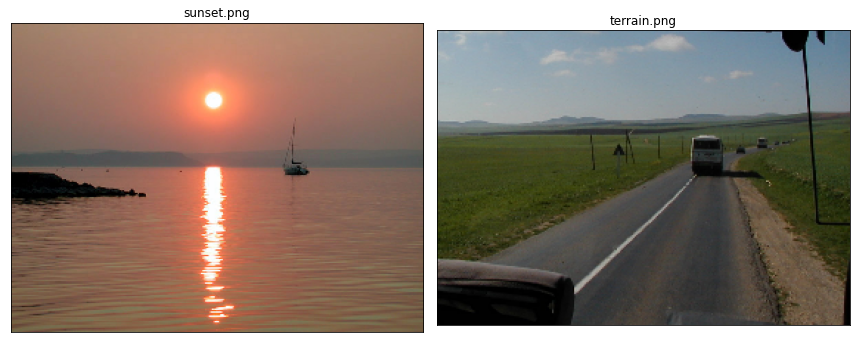

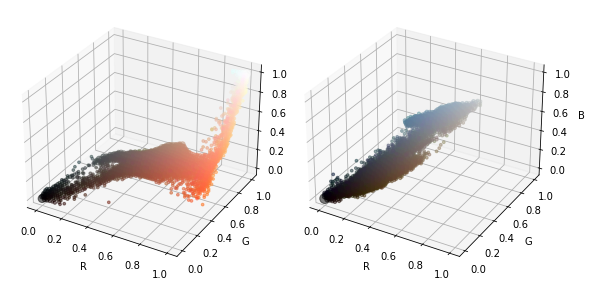

In [160]:
def plot_3d_histogram(ax, data, axis_names='xyz'):
    """Plot a 3D histogram. We plot a sphere for each bin,
    with volume proportional to the bin content."""
    r,g,b = np.meshgrid(*[np.linspace(0,1, dim) for dim in data.shape], indexing='ij')
    colors = np.stack([r,g,b], axis=-1).reshape(-1, 3)
    marker_sizes = 300 * data**(1/3)
    ax.scatter(r.flat, g.flat, b.flat, s=marker_sizes.flat, c=colors, alpha=0.5)
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.set_zlabel(axis_names[2])

paths = ['sunset.png', 'terrain.png']
images = [imageio.imread(p) for p in paths]
plot_multiple(images, paths)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': '3d'})
for path, ax in zip(paths, axes):
    im = imageio.imread(path).astype(np.float32)/256
    hist = compute_3d_histogram(im, n_bins=50) # <--- FIDDLE WITH N_BINS HERE
    plot_3d_histogram(ax, hist, 'RGB')   
fig.tight_layout()

## Histograms in 2D

Now modify your code to work in 2D. This can be useful, for example, for a gradient image that stores two values for each pixel: the vertical and horizontal derivative. Again, assume the values are in the range \[0,1).

Since gradients can be negative, we need to pick a relevant range of values an map them linearly to the range of \[0,1) before applying `compute_2d_histogram`. This is implemented by the function `map_range` provided at the beginning of the notebook.

In 2D we can plot the histogram as an image. For better visibility of small values, we plot the logarithm of each bin value. Yellowish colors mean high values. The center is (0,0). Can you explain why each histogram looks the way it does for the test images?

In [161]:
# POINTS: 3

def compute_2d_histogram(im, n_bins):
    histogram = np.zeros([n_bins, n_bins], dtype=np.float32)

    bin_width = 1 / n_bins

    def calculate_indices(values):
        indices = np.floor_divide(values, bin_width)
        return tuple(indices.astype(int))
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            histogram[calculate_indices(im[i, j])] += 1

    histogram /= (im.shape[0] * im.shape[1])
    
    return histogram

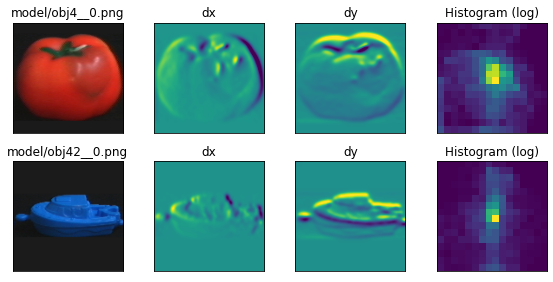

In [162]:
def compute_gradient_histogram(rgb_im, n_bins):
    # Convert to grayscale
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY).astype(float)
    # Compute Gaussian derivatives
    dx, dy = gauss_derivs(gray_im, sigma=2.0)
    # Map the derivatives between -10 and 10 to be between 0 and 1
    dx = map_range(dx, start=-10, end=10)
    dy = map_range(dy, start=-10, end=10)
    # Stack the two derivative images along a new
    # axis at the end (-1 means "last")
    gradients = np.stack([dy, dx], axis=-1)
    return dx, dy, compute_2d_histogram(gradients, n_bins=16)

paths = ['model/obj4__0.png', 'model/obj42__0.png']
images, titles = [], []

for path in paths:
    im = imageio.imread(path)
    dx, dy, hist = compute_gradient_histogram(im, n_bins=16)
    images += [im, dx, dy, np.log(hist+1e-3)]
    titles += [path, 'dx', 'dy', 'Histogram (log)']
    
plot_multiple(images, titles, max_columns=4, imwidth=2,
              imheight=2, colormap='viridis')

Similar to the function `compute_gradient_histogram` above, we can build a "Mag/Lap" histogram from the gradient magnitudes and the Laplacians at each pixel. Refer back to the first exercise to refresh your knowledge of the Laplacian. Implement this in `compute_maglap_histogram`!

Make sure to map the relevant range of the gradient magnitude and Laplacian values to \[0,1) using `map_range()`. For the magnitude you can assume that the values will mostly lie in the range \[0, 15) and the Laplacian in the range \[-5, 5).

In [163]:
# POINTS: 3

def compute_maglap_histogram(rgb_im, n_bins):
    # Convert to grayscale
    gray_im = cv2.cvtColor(rgb_im, cv2.COLOR_RGB2GRAY).astype(float)
    # Compute Gaussian derivatives
    sigma = 2
    kernel_radius = np.ceil(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, sigma)
    D = gaussdx(x, sigma)
    dx = convolve_with_two(gray_im, D, G.T)
    dy = convolve_with_two(gray_im, G, D.T)
    
    # Compute second derivatives
    dxx = convolve_with_two(dx, D, G.T)
    dyy = convolve_with_two(dy, G, D.T)

    mag = np.sqrt(dx**2 + dy**2)
    mag = map_range(mag, 0, 15)
    lap = dxx + dyy 
    lap = map_range(lap, -5, 5)
    
    mag_lap = np.stack([mag, lap], axis=-1)

    return mag, lap, compute_2d_histogram(mag_lap, n_bins=16)

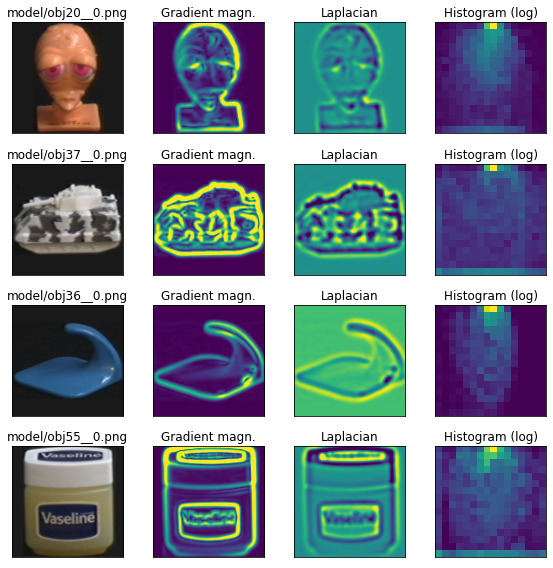

In [164]:
paths = [f'model/obj{i}__0.png' for i in [20, 37, 36, 55]]
images, titles = [], []

for path in paths:
    im = imageio.imread(path)
    mag, lap, hist = compute_maglap_histogram(im, n_bins=16)
    images += [im, mag, lap, np.log(hist+1e-3)]
    titles += [path, 'Gradient magn.', 'Laplacian', 'Histogram (log)']
    
plot_multiple(images, titles, imwidth=2, imheight=2,
              max_columns=4, colormap='viridis')

## Comparing Histograms

The above histograms looked different, but to quantify this objectively, we need a **distance measure**. The Euclidean distance is a common one.
Implement the function `euclidean_distance`, which takes two histograms $P$ and $Q$ as input and returns their Euclidean distance:

$$
\textit{dist}_{\textit{Euclidean}}(P, Q) = \sqrt{\sum_{i=1}^{D}{(P_i - Q_i)^2}}
$$

Another commonly used distance for histograms is the so-called chi-squared ($\chi^2$) distance, commonly defined as:

$$
\chi^2(P, Q) = \frac{1}{2} \sum_{i=1}^{D}\frac{(P_i - Q_i)^2}{P_i + Q_i + \epsilon}
$$

Where we can use a small value $\epsilon$ is used to avoid division by zero.
Implement it as `chi_square_distance`. The inputs `hist1` and `hist2` are histogram vectors containing the bin values. Remember to use numpy array functions (such as `np.sum()`) instead of looping over each element in Python (looping is slow).

In [200]:
# POINTS: 2

def euclidean_distance(hist1, hist2):
    dif = hist1.ravel() - hist2.ravel()
    return np.sqrt(np.dot(dif, dif))
    

def chi_square_distance(hist1, hist2, eps=1e-3):
    return 1/2 * np.sum((hist1 - hist2)**2 / (hist1 + hist2 + eps))

Now let's take the image `obj1__0.png` as reference and let's compare it to `obj91__0.png` and `obj94__0.png`, using an RGB histogram, both with Euclidean and chi-square distance. Can you interpret the results?

You can also try other images from the "model" folder.

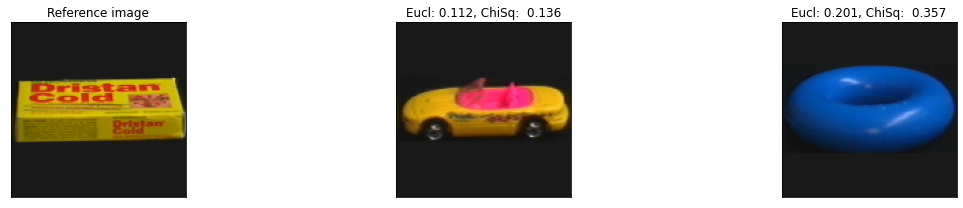

In [201]:
im1 = imageio.imread('model/obj1__0.png')
im2 = imageio.imread('model/obj91__0.png')
im3 = imageio.imread('model/obj94__0.png')
n_bins = 8
h1 = compute_3d_histogram(im1/256, n_bins)
h2 = compute_3d_histogram(im2/256, n_bins)
h3 = compute_3d_histogram(im3/256, n_bins)

eucl_dist1 = euclidean_distance(h1, h2)
chisq_dist1 = chi_square_distance(h1, h2)
eucl_dist2 = euclidean_distance(h1, h3)
chisq_dist2 = chi_square_distance(h1, h3)

titles = ['Reference image',
          f'Eucl: {eucl_dist1:.3f}, ChiSq:  {chisq_dist1:.3f}',
          f'Eucl: {eucl_dist2:.3f}, ChiSq:  {chisq_dist2:.3f}']
plot_multiple([im1, im2, im3], titles, imheight=3)

# Keypoint Detection

Now we turn to finding keypoints in images.

## Harris Detector

The Harris detector searches for points, around which the second-moment matrix $M$ of the gradient vector has two large eigenvalues (This $M$ is denoted by $C$ in the Grauman & Leibe script). This matrix $M$ can be written as:

$$
M(\sigma, \tilde{\sigma}) = G(\tilde{\sigma}) \star \left[\begin{matrix} I_x^2(\sigma) & I_x(\sigma) \cdot I_y(\sigma) \cr I_x(\sigma)\cdot I_y(\sigma) & I_y^2(\sigma) \end{matrix}\right]
$$

Note that the matrix $M$ is computed for each pixel (we omitted the $x, y$ dependency in this formula for clarity). In the above notation the 4 elements of the second-moment matrix are considered as full 2D "images" (signals) and each of these 4 "images" are convolved with the Gaussian $G(\tilde{\sigma})$ independently. We have two sigmas $\sigma$ and $\tilde{\sigma}$ here for two different uses of Gaussian blurring:

  * first for computing the derivatives themselves (as derivatives-of-Gaussian) with $\sigma$, and
  * then another Gaussian with $\tilde{\sigma}$ that operates on "images" containing the *products* of the derivatives (such as $I_x^2(\sigma)$) in order to collect summary statistics from a window around each point.

Instead of explicitly computing the eigenvalues $\lambda_1$ and $\lambda_2$ of $M$, the following equivalences are used:

$$
\det(M) = \lambda_1 \lambda_2 = (G(\tilde{\sigma}) \star I_x^2)\cdot (G(\tilde{\sigma}) \star I_y^2) - (G(\tilde{\sigma}) \star (I_x\cdot I_y))^2
$$

$$
\mathrm{trace}(M) = \lambda_1 + \lambda_2 = G(\tilde{\sigma}) \star I_x^2 + G(\tilde{\sigma}) \star I_y^2
$$

The Harris criterion is then:

$$
\det(M) - \alpha \cdot \mathrm{trace}^2(M) > t
$$

In practice, the parameters are usually set as $\tilde{\sigma} = 2 \sigma, \alpha=0.06$.
Read more in Section 3.2.1.2 of the Grauman & Leibe script (grauman-leibe-ch3-local-features.pdf in the Moodle).

----

Write a function `harris_score(im, opts)` which:
  - computes the values of $M$ **for each pixel** of the grayscale image `im`
  - calculates the trace and the determinant at each pixel
  - combines them to the Harris response and returns the resulting image

To handle the large number of configurable parameters in this exercise, we will store them in an `opts` object. Use `opts.sigma1` for $\sigma$, `opts.sigma2` for $\tilde{\sigma}$ and `opts.alpha` for $\alpha$.

Furthermore, implement `nms(scores)` to perform non-maximum suppression of the response image.

Then look at `score_map_to_keypoints(scores, opts)`. It takes a score map and returns an array of shape `[number_of_corners, 2]`, with each row being the $(x,y)$ coordinates of a found keypoint. We use `opts.score_threshold` as the threshold for considering a point to be a keypoint. (This is quite similar to how we found detections from score maps in the sliding-window detection exercise.)

In [167]:
# POINTS: 7

def harris_scores(im, opts):
    dx, dy = gauss_derivs(im, opts.sigma1)

    det = gauss_filter(dx**2, opts.sigma1) * gauss_filter(dy**2, opts.sigma1) - gauss_filter(dx*dy, opts.sigma1)**2
    trace = gauss_filter(dx**2, opts.sigma1) + gauss_filter(dy**2, opts.sigma1)

    scores = det - opts.alpha * trace**2

    return scores

In [168]:
# POINTS: 3

def nms(scores):
    scores_padded = np.pad(scores, 1, 'constant', constant_values=scores.min())
    scores_out = np.full_like(scores, scores.min())
    
    # Loop over pixels without padding
    for x in range(1, scores_padded.shape[1]-1):
        for y in range(1, scores_padded.shape[0]-1):
            # Check if pixel larger than all sorrounding values
            if np.all(scores_padded[y-1:y+2, x-1:x+2] <= scores_padded[y, x]):
                scores_out[y-1, x-1] = scores_padded[y, x]

    return scores_out

In [169]:
def score_map_to_keypoints(scores, opts):
    corner_ys, corner_xs = (scores > opts.score_threshold).nonzero()
    return np.stack([corner_xs, corner_ys], axis=1)

Now check the score maps and keypoints:

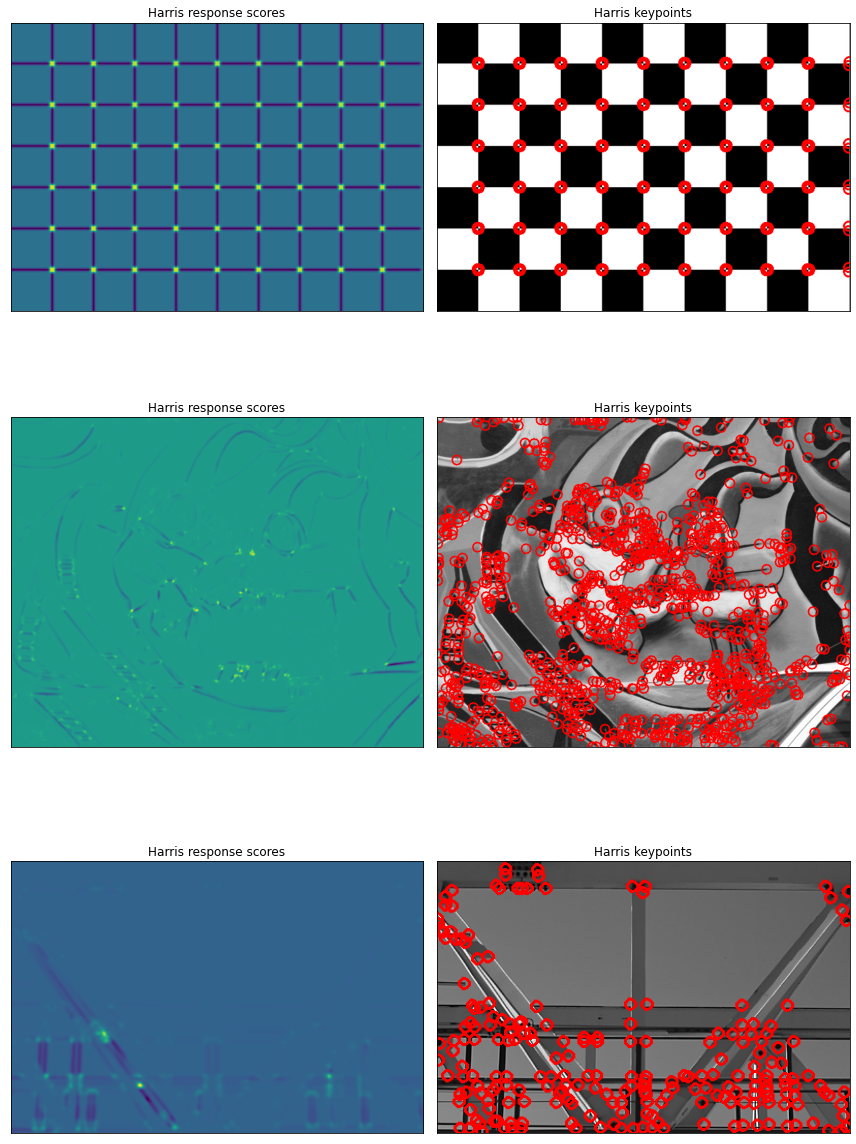

In [170]:
opts = AttrDict()
opts.sigma1=2
opts.sigma2=opts.sigma1*2
opts.alpha=0.06
opts.score_threshold=1e-8

paths = ['checkboard.jpg', 'graf.png', 'gantrycrane.png']
images = []
titles = []
for path in paths:
    image = load_image(path)
    
    score_map = harris_scores(image, opts)
    score_map_nms = nms(score_map)
    keypoints = score_map_to_keypoints(score_map_nms, opts)
    keypoint_image = draw_keypoints(image, keypoints)

    images += [score_map, keypoint_image]
    titles += ['Harris response scores', 'Harris keypoints']
plot_multiple(images, titles, max_columns=2, colormap='viridis')

## Hessian Detector
The Hessian detector operates on the second-derivative matrix $H$ (called the “Hessian” matrix)

$$
H = \left[\begin{matrix}I_{xx}(\sigma) & I_{xy}(\sigma) \cr I_{xy}(\sigma) & I_{yy}(\sigma)\end{matrix}\right] \tag{6}
$$

Note that these are *second* derivatives, while the Harris detector computes *products* of *first* derivatives! The score is computed as follows:

$$
\sigma^4 \det(H) = \sigma^4 (I_{xx}I_{yy} - I^2_{xy}) > t \tag{7}
$$

You can read more in Section 3.2.1.1 of the Grauman & Leibe script (grauman-leibe-ch3-local-features.pdf in the Moodle).

-----

Write a function `hessian_scores(im, opts)`, which:
  - computes the four entries of the $H$ matrix for each pixel of a given image, 
  - calculates the determinant of $H$ to get the response image

Use `opts.sigma1` for computing the Gaussian second derivatives.

In [171]:
# POINTS: 7

def hessian_scores(im, opts):
    scores = np.zeros_like(im)
    height, width = im.shape
    dxx, dxy, dyy = gauss_second_derivs(image, opts.sigma1)

    scores = opts.sigma1**4 * (dxx * dyy - dxy**2)

    return scores

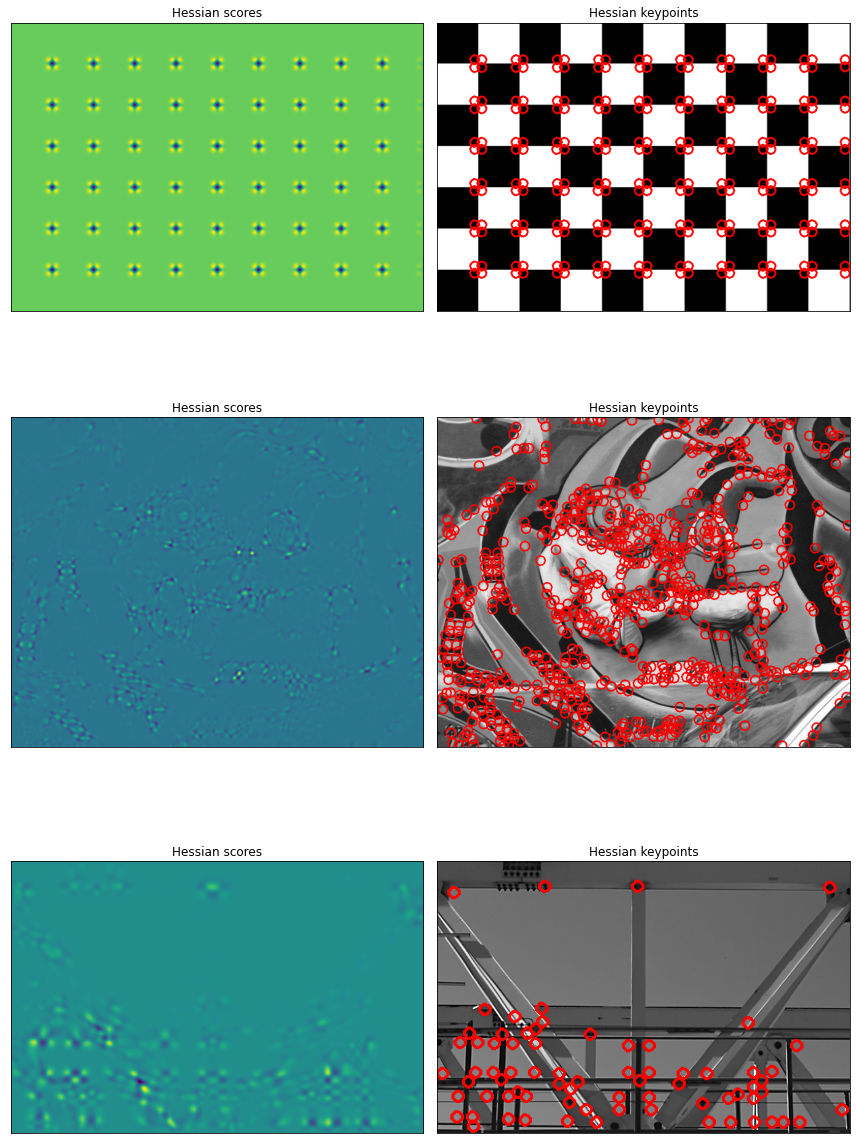

In [172]:
opts = AttrDict()
opts.sigma1=3
opts.score_threshold=5e-4

paths = ['checkboard.jpg', 'graf.png', 'gantrycrane.png']
images = []
titles = []
for path in paths:
    image = load_image(path)
    score_map = hessian_scores(image, opts)
    score_map_nms = nms(score_map)
    keypoints = score_map_to_keypoints(score_map_nms, opts)
    keypoint_image = draw_keypoints(image, keypoints)
    images += [score_map, keypoint_image]
    titles += ['Hessian scores', 'Hessian keypoints']
    
plot_multiple(images, titles, max_columns=2, colormap='viridis')

## Region Descriptor Matching

Now that we can detect robust keypoints, we can try to match them across different images of the same object. For this we need a way to compare the neighborhood of a keypoint found in one image with the neighborhood of a keypoint found in another. If the neighborhoods are similar, then the keypoints may represent the same physical point on the object.

To compare two neighborhoods, we compute a **descriptor** vector for the image window around each keypoint and then compare these descriptors using a **distance function**.

Inspect the following `compute_rgb_descriptors` function that takes a window around each point in `points` and computes a 3D RGB histogram and returns these as row vectors in a `descriptors` array.


In [ ]:
def compute_rgb_descriptors(rgb_im, points, opts):
    """For each (x,y) point in `points` calculate the 3D RGB histogram 
    descriptor and stack these into a matrix 
    of shape [num_points, descriptor_length]
    """
    win_half = opts.descriptor_window_halfsize
    descriptors = []
    rgb_im_01 = rgb_im.astype(np.float32)/256
    height, width = rgb_im.shape[:2]
    
    for (x, y) in points:
        y_start = max(0, y-win_half)
        y_end = min(y+win_half+1, height)
        x_start = max(0, x-win_half)
        x_end = min(x+win_half+1, width)
        window = rgb_im_01[y_start:y_end, x_start:x_end]
        histogram = compute_3d_histogram(window, opts.n_histogram_bins)
        descriptors.append(histogram.reshape(-1))

    return np.array(descriptors)

Now write the function `compute_maglap_descriptors`, which works very similarly to `compute_rgb_descriptors`, but computes two-dimensional gradient-magnitude/Laplacian histograms. (Compute the gradient magnitude and the Laplacian for the full image first. See also the beginning of this exercise.) Pay attention to the scale of the gradient-magnitude values.

In [ ]:
# POINTS: 7

def compute_maglap_descriptors(rgb_im, points, opts):
    """For each (x,y) point in `points` calculate the magnitude-Laplacian
    2D histogram descriptor and stack these into a matrix of
    shape [num_points, descriptor_length]
    """    
    # Compute the gradient magnitude and Laplacian for each pixel first
    gray_im = cv2.cvtColor(rgb_im, cv2.COLOR_RGB2GRAY).astype(float)
    kernel_radius = np.ceil(3.0 * opts.sigma1)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    G = gauss(x, opts.sigma1)
    D = gaussdx(x, opts.sigma1)
    dx = convolve_with_two(gray_im, D, G.T)
    dy = convolve_with_two(gray_im, G, D.T)
    dxx = convolve_with_two(dx, D, G.T)
    dyy = convolve_with_two(dy, G, D.T)

    mag = np.sqrt(dx**2 + dy**2)
    mag = map_range(mag, 0, 15)
    lap = dxx + dyy 
    lap = map_range(lap, -5, 5)
    
    # Compute maglap
    win_half = opts.descriptor_window_halfsize
    height, width = gray_im.shape

    descriptors = []

    for (x, y) in points:
        y_start = max(0, y-win_half)
        y_end = min(y+win_half+1, height)
        x_start = max(0, x-win_half)
        x_end = min(x+win_half+1, width)
        window = rgb_im[y_start:y_end, x_start:x_end]
        _, _, mag_lap = compute_maglap_histogram(window, opts.n_histogram_bins)
        #print(mag_lap.shape, 8 * opts.descriptor_window_halfsize**2)
        descriptors.append(mag_lap.reshape(-1))

    return np.array(descriptors)

Now let's implement the distance computation between descriptors. Look at `compute_euclidean_distances`. It takes descriptors that were computed for keypoints found in two different images and returns the pairwise distances between all point pairs.


In [ ]:
def compute_euclidean_distances(descriptors1, descriptors2):
    distances = np.empty((len(descriptors1), len(descriptors2)))
    for i, desc1 in enumerate(descriptors1):
        distances[i] = np.linalg.norm(descriptors2-desc1, axis=-1)
    return distances

Implement `compute_chi_square_distances` in a similar manner.

In [208]:
# POINTS: 3

def compute_chi_square_distances(descriptors1, descriptors2, eps=1e-3):
    distances = np.empty((len(descriptors1), len(descriptors2)))
    for i, desc1 in enumerate(descriptors1):
        for j, desc2 in enumerate(descriptors2):
            distances[i, j] = 1/2 * np.sum((desc2 - desc1)**2 / (desc2 + desc1 + eps))
    return distances

Given the distances, a simple way to produce point matches is to take each descriptor extracted from a keypoint of the first image, and find the keypoint in the second image with the nearest descriptor. The full pipeline from images to point matches is implemented below in the function `find_point_matches(im1, im2, opts)`.

Experiment with different parameter settings. Which keypoint detector, region descriptor and distance function works best?

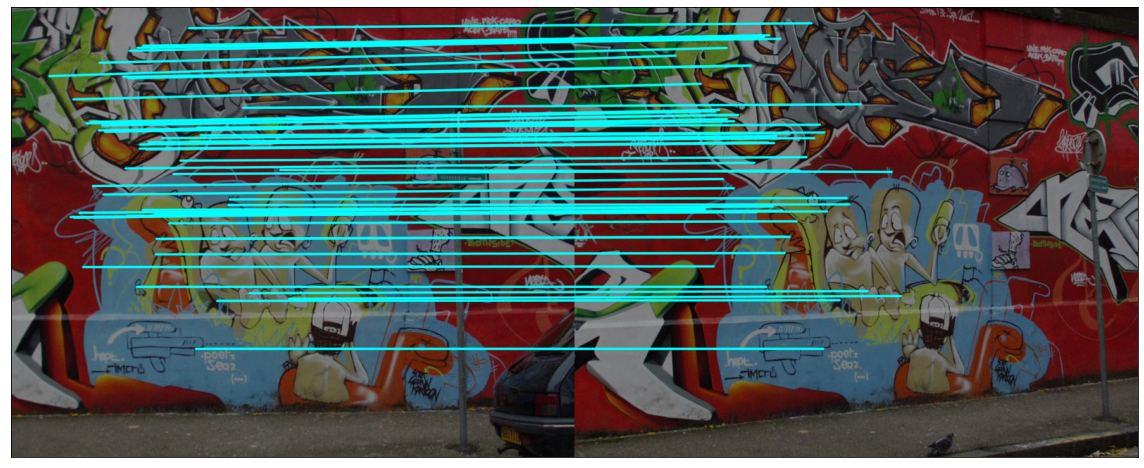

In [211]:
def find_point_matches(im1, im2, opts):
    # Process first image
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY).astype(float)/255
    score_map1 = nms(opts.score_func(im1_gray, opts))
    points1 = score_map_to_keypoints(score_map1, opts)
    descriptors1 = opts.descriptor_func(im1, points1, opts)

    # Process second image independently of first
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY).astype(float)/255
    score_map2 = nms(opts.score_func(im2_gray, opts))
    points2 = score_map_to_keypoints(score_map2, opts)
    descriptors2 = opts.descriptor_func(im2, points2, opts)
    
    # Compute descriptor distances
    distances = opts.distance_func(descriptors1, descriptors2)
    
    # Find the nearest neighbor of each descriptor from the first image
    # among descriptors of the second image
    closest_ids = np.argmin(distances, axis=1)
    closest_dists = np.min(distances, axis=1)
    
    # Sort the point pairs in increasing order of distance
    # (most similar ones first)
    ids1 = np.argsort(closest_dists)
    ids2 = closest_ids[ids1]
    points1 = points1[ids1]
    points2 = points2[ids2]
    
    # Stack the point matches into rows of (x1, y1, x2, y2) values
    point_matches = np.concatenate([points1, points2], axis=1)
    return point_matches

# Try changing these values in different ways and see if you can explain
# why the result changes the way it does.
opts = AttrDict()
opts.sigma1=2
opts.sigma2=opts.sigma1*2
opts.alpha=0.06
opts.score_threshold=1e-8
opts.descriptor_window_halfsize = 20
opts.n_histogram_bins = 16
opts.score_func = harris_scores
opts.descriptor_func = compute_maglap_descriptors
#opts.distance_func = compute_chi_square_distances
opts.distance_func = compute_euclidean_distances

# Or try these:
# opts.sigma1=3
# opts.n_histogram_bins = 8
# opts.score_threshold=5e-4
# opts.score_func = hessian_scores
# opts.descriptor_func = compute_rgb_descriptors
# opts.distance_func = compute_euclidean_distances

im1 = imageio.imread('graff5/img1.jpg')
im2 = imageio.imread('graff5/img2.jpg')

point_matches = find_point_matches(im1, im2, opts)
match_image = draw_point_matches(im1, im2, point_matches[:50])
plot_multiple([match_image], imwidth=16, imheight=8)

## Homography Estimation

Now that we have these pairs of matching points (also called point correspondences), what can we do with them? In the above case, the wall is planar (flat) and the camera was moved towards the left to take the second image compared to the first image. Therefore, the way that points on the wall are transformed across these two images can be modeled as a **homography**. Homographies can model two distinct effects:

  * transformation across images of **any scene** taken from the **exact same camera position** (center of projection)
  * transformation across images of a **planar object** taken from **any camera position**.
  
We are dealing with the second case in these graffiti images. Therefore if our point matches are correct, there should be a homography that transforms image points in the first image to the corresponding points in the second image. Recap the algorithm from the lecture for finding this homography (it's called the **Direct Linear Transformation**, DLT). There is a 2 page description of it in the Grauman & Leibe script (grauman-leibe-ch5-geometric-verification.pdf in the Moodle) in Section 5.1.3.

----

Now let's actually put this into practice. Implement `estimate_homography(point_matches)`, which returns a 3x3 homography matrix that transforms points of the first image to points of the second image.
The steps are:

  1. Build the matrix $A$ from the point matches according to Eq. 5.7 from the script.
  2. Apply SVD using `np.linalg.svd(A)`. It returns $U,d,V^T$. Note that the last return value is not $V$ but $V^T$.
  3. Compute $\mathbf{h}$ from $V$ according to Eq. 5.9 or 5.10
  4. Reshape $\mathbf{h}$ to the 3x3 matrix $H$ and return it.
  
The input `point_matches` contains as many rows as there are point matches (correspondences) and each row has 4 elements: $x, y, x', y'$.

In [199]:
# POINTS: 7

def estimate_homography(point_matches):
    n_matches = len(point_matches)
    A = np.empty((n_matches*2, 9))
    for i, (x1, y1, x2, y2) in enumerate(point_matches):
    # YOUR CODE HERE
    raise NotImplementedError()
    return H

IndentationError: expected an indented block (<ipython-input-199-e81407230cdf>, line 8)

The `point_matches` have already been sorted in the `find_point_matches` function according to the descriptor distances, so the more accurate pairs will be near the beginning. We can use the top $k$, e.g. $k=10$ pairs in the homography estimation and have a reasonably accurate estimate. What $k$ give the best result? What happens if you use too many? Why?

We can use `cv2.warpPerspective` to warp the first image to the reference frame of the second. Does the result look good?

Can you interpret the entries of the resulting $H$ matrix and are the numbers as you would expect them for these images?

You can also try other image from the `graff5` folder or the `NewYork` folder.

In [ ]:
# See what happens if you change top_k below
top_k = 50
H = estimate_homography(point_matches[:top_k])

H_string = np.array_str(H, precision=5, suppress_small=True)
print('The estimated homography matrix H is\n', H_string)

im1_warped = cv2.warpPerspective(im1, H, (im2.shape[1], im2.shape[0]))
absdiff = np.abs(im2.astype(np.float32)-im1_warped.astype(np.float32))/255
plot_multiple([im1, im2, im1_warped, absdiff],
              ['First image', 'Second image', 
               'Warped first image', 'Absolute difference'],
              max_columns=2, colormap='viridis')